### Task 2

b) 
For the surface plot I used a SVD (singular value decomposition) to reduce dimensionality and project the data points to a 2D plane. The axes were determined by the 2 most significant features.

The k I chose (25), was not too small as to make the decision bundary jagged (as the model would be sensitive to infrequent noise points); and was not too large as to have classification affected by irrelevent classes. 

I used the euclidean distance metric to determine the 25 nearest neighbours. This affected the decision boundary by???

In [400]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("../../train.csv")
X_train = df["Text"].values
X_data = df["Text"]
y_train= df["Category"].values
y_data = df["Category"]

df = pd.read_csv("../../test.csv")
X_test = df["Text"].values
y_test= df["Category"].values

vectoriser = TfidfVectorizer()
X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)




TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

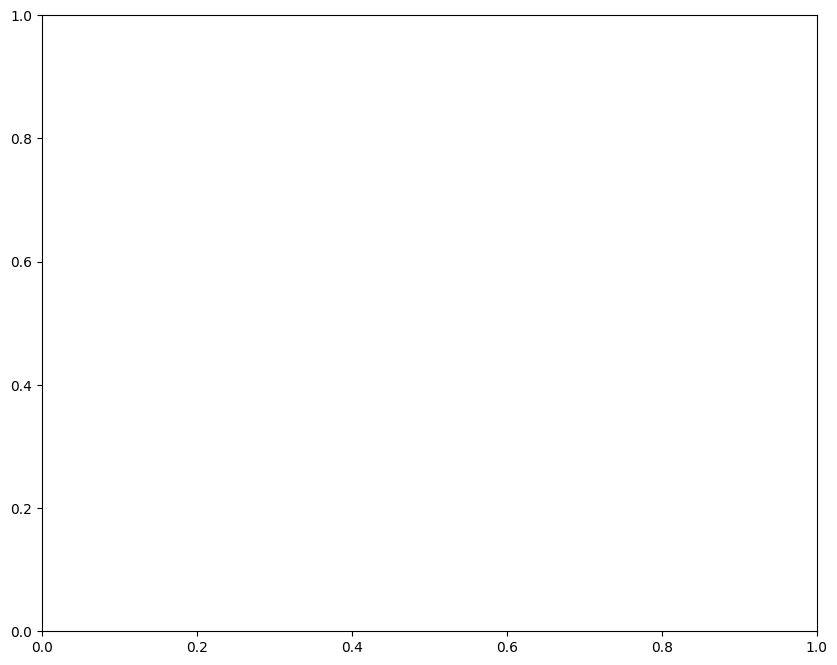

In [401]:
def build_classifier(k, p, training_vec, y):
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=p)
    knn.fit(training_vec, y)
    return knn

def predict_class(knn, testing_vec):
    return knn.predict(testing_vec)

def create_surface_plot(y_pred, k, metric, top_n):
    # Reduce to 2D using Truncated SVD (works with sparse TF-IDF)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_train_2d = svd.fit_transform(X_train_vec)
    X_test_2d = svd.transform(X_test_vec)

    # Get feature names for axis labels
    feature_names = vectoriser.get_feature_names_out()
    comp1_words = [feature_names[i] for i in np.argsort(svd.components_[0])[::-1][:top_n]]
    comp2_words = [feature_names[i] for i in np.argsort(svd.components_[1])[::-1][:top_n]]
    x_label = f"Component 1: {' + '.join(comp1_words)}"
    y_label = f"Component 2: {' + '.join(comp2_words)}"

    # Train kNN on the projected training data
    knn_2d = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=(1 if metric == 'manhatan' else 2))
    knn_2d.fit(X_train_2d, y_train)

    # Create meshgrid for decision surface
    h = 0.3
    x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
    y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_numeric = pd.factorize(Z)[0].reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))

    # Scatter the actual test points
    for label in np.unique(y_pred):
        idx = y_pred == label
        plt.scatter(X_test_2d[idx, 0], X_test_2d[idx, 1], label=f'Predicted: {label}', edgecolor='k', s=70)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"kNN Decision Surface (k={k}, metric='{metric}')")
    plt.legend()
    plt.grid(True)
    plt.show()

def kNN_surface_plot():
    k = 25
    distance_metrics = ["manhatan", "euclidean"]
    metric = "euclidean"
    p = distance_metrics.index(metric) + 1
    
    knn = build_classifier(k, p, X_train_vec, y_train)
    y_pred = predict_class(knn, X_test_vec)
    
    create_surface_plot(y_pred, k, metric, 2)
    
kNN_surface_plot()


### Task 3

(a) We explore how the size of the training data set affects the test and train accuracy. For each
value of m in [0.1, 0.3, 0.5, 0.7, 0.9], train your classifier on the first m portion of the training
examples (that is, use the data given by XTrain[0:mN] and yTrain[0:mN]). Please report two
plots: (i) training and (ii) testing accuracy for each such value of m with the x-axis referring to m
and the y-axis referring to the classification accuracy in 𝐹1 measure as shown below. In total,
there should be four curves for training accuracy and four curves for testing accuracy. Explain
the general trend of the two plots in terms of training and testing accuracy if any.

create plot with each proportion m of training data. Two lines/plots, one for testing accuracy (F1 measure) the othger for train accuracy (F1 measure).

Explain findings



Train Accuracy: 0.9322429906542056
Test Accuracy: 0.9150943396226415
Train Accuracy: 0.9626168224299065
Test Accuracy: 0.9622641509433962
Train Accuracy: 0.9766355140186916
Test Accuracy: 0.9811320754716981
Train Accuracy: 0.9789719626168224
Test Accuracy: 0.9716981132075472
Train Accuracy: 0.9766355140186916
Test Accuracy: 0.9811320754716981


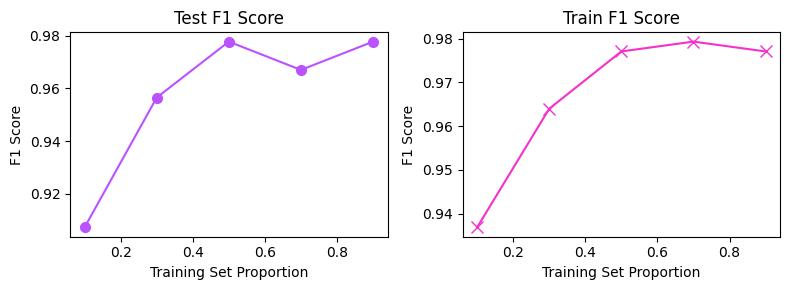

In [ ]:
def train_on_m(m, k, p):
    sub_X_train = X_train_vec[0:round(X_train_vec.shape[0]*m)]
    sub_y_train = y_train[0:round(len(y_train)*m)]

    knn = build_classifier(k, p, sub_X_train, sub_y_train)
    train_pred = predict_class(knn, X_train_vec)
    test_pred = predict_class(knn, X_test_vec)
    
    train_f1 = calc_f1(train_pred, y_train)
    test_f1 = calc_f1(test_pred, y_test)

    
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    return train_f1, test_f1
    

def calc_f1(preds, actual):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    # tech is positive
    for i in range(len(preds)):
        if preds[i] == "tech" and actual[i] == "tech":
            tp += 1
        elif preds[i] == "tech" and actual[i] == "entertainment":
            fp += 1
        elif preds[i] == "entertainment" and actual[i] == "entertainment":
            tn += 1
        else:
            fn += 1
    precision = tp / (tp + fp) if tp+fp >0 else 0
    recall = tp / (tp + fn) if tp+fn>0 else 0
    f1 = 2*((precision*recall) / (precision+recall)) if precision+recall>0 else 0

    return f1

def create_f1_plots():
    k = 5
    distance_metrics = ["manhatan", "euclidean"]
    metric = "euclidean"
    p = distance_metrics.index(metric) + 1

    ms = [0.1, 0.3, 0.5, 0.7, 0.9]
    test_f1s = []
    train_f1s = []

    for m in ms:
        train_f1, test_f1 = train_on_m(m, k, p)
        test_f1s.append(test_f1)
        train_f1s.append(train_f1)


    fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns

    # Plot test F1
    axes[0].plot(ms, test_f1s, marker="o", color="#BA52FF", markersize=7)
    axes[0].set_title("Test F1 Score")
    axes[0].set_xlabel("Training Set Proportion")
    axes[0].set_ylabel("F1 Score")

    # Plot train F1
    axes[1].plot(ms, train_f1s, marker="x", color="#F431CB", markersize=8)
    axes[1].set_title("Train F1 Score")
    axes[1].set_xlabel("Training Set Proportion")
    axes[1].set_ylabel("F1 Score")

    plt.tight_layout()  # Prevent overlap
    plt.show()
        
create_f1_plots()

(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key
hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the
classification accuracy may be significantly affected by the kernels and hyperparameter
combination. List hyperparameters for each classifier and demonstrate how these
hyperparameters impact on the testing accuracy.

assess different k's
assess diffferent distance metrics


In [ ]:
# Encode y_data once
#label_encoder = LabelEncoder()
#y_encoded = label_encoder.fit_transform(y_data)

def hyperperameter_test():
    folds = 5
    distance_metrics = ["manhatan", "euclidean"]

    highscore = 0
    best_k = None
    best_metric = None
    k_vals = [1, 5, 10, 100]
    for k in k_vals:
        for metric in distance_metrics:
            p = distance_metrics.index(metric) + 1
            score = k_fold_crossval(k, p, folds, y_encoded)
            if score > highscore:
                best_metric = distance_metrics[p - 1]
                best_k = k
            print(f"k = {k} and metric = {distance_metrics[p - 1]} gives score = {score:.4f}")

    print(f"\nThe best hyperparameter k is {best_k} and best metric is {best_metric}")

def k_fold_crossval(k, p, folds, y_encoded):
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    f1_scores = []
    vectorizer = TfidfVectorizer()

    for train_index, test_index in kf.split(X_data):
        X_train_fold, X_test_fold = X_data.iloc[train_index], X_data.iloc[test_index]
        y_train_fold, y_test_fold = y_encoded[train_index], y_encoded[test_index]

        X_train_fold_vec = vectorizer.fit_transform(X_train_fold)
        X_test_fold_vec = vectorizer.transform(X_test_fold)

        knn = build_classifier(k, p, X_train_fold_vec, y_train_fold)
        y_pred = predict_class(knn, X_test_fold_vec)

        f1 = calc_f1(y_pred, y_test_fold)
        f1_scores.append(f1)

    return np.mean(f1_scores)

hyperperameter_test()

TypeError: StratifiedKFold.split() missing 1 required positional argument: 'y'